# Detecção de Mudanças

Escolhendo uma cidade: Águas Claras


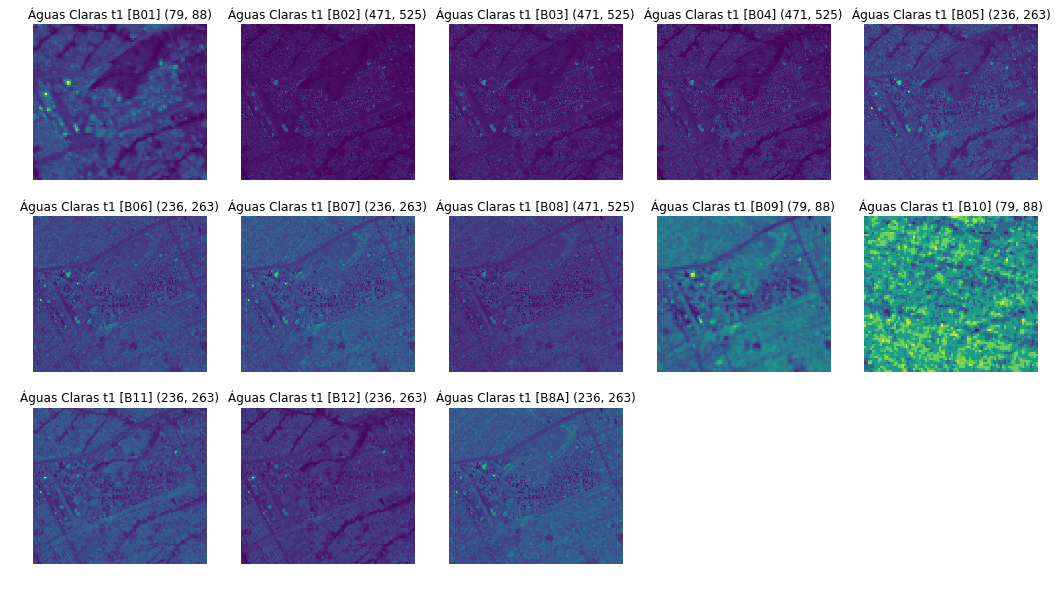

In [131]:
import glob
from skimage import io
import matplotlib.pyplot as plt
import numpy as np


def get_spectral_band_from_image_name(image_name):
    '''
    Exemplo de nome de imagem: S2A_OPER_MSI_L1C_TL_SGS__20160927T081713_A006607_T49QHE_B01.tif
    '''
    import re

    match = re.search(r"_(B[\da-zA-Z]{2})\.tif", image_name, re.I)
    if (match == None):
        return None
    return match.group(1)


def import_all_files_from_directory(path):
    '''
    Carrega todas as imagens do diretório especificado.
    Retorna, para cada imagem, uma tupla contendo:
        - um np.ndarray com seu conteúdo
        - uma string informando a banda espectral amostrada na imagem
    '''
    images = []
    for filename in glob.glob('{}/*.tif'.format(path)):
        image = io.imread(filename)
        band = get_spectral_band_from_image_name(filename)
        images.append((image, band))

    return images

def show_all_bands(images, title=''):
    fig, axes = plt.subplots(3, 5, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, image in enumerate(images):
        axes[i].imshow(image[0])
        axes[i].set_title('{} [{}] {}'.format(title, image[1], image[0].shape))

    for ax in axes:
        ax.set_axis_off()
    
    plt.show()

def show_compare(left, right, left_title='', right_title=''):
    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(18, 12))
    left_ax.imshow(left)
    left_ax.set_axis_off()
    left_ax.set_title('{} {}'.format(left_title, left.shape))
    right_ax.imshow(right)
    right_ax.set_axis_off()
    right_ax.set_title('{} {}'.format(right_title, right.shape))
    plt.show()
    
def show(image):
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    ax.imshow(image)
    ax.set_axis_off()
    plt.show()


cities = ['abudhabi', 'aguasclaras', 'beihai', 'beirut', 'bercy', 'bordeaux', 'brasilia', 'chongqing', 'cupertino', 'dubai', 'hongkong', 'lasvegas', 'milano', 'montpellier', 'mumbai', 'nantes', 'norcia', 'paris', 'pisa', 'rennes', 'rio', 'saclay_e', 'saclay_w', 'valencia']
cities_with_ground_truths = ['abudhabi', 'aguasclaras', 'beihai', 'beirut', 'bercy', 'bordeaux', 'cupertino', 'hongkong', 'mumbai', 'nantes', 'paris', 'pisa', 'rennes', 'saclay_e']

cities_sources = list(map(lambda city: import_all_files_from_directory('onera-images/{}/imgs_1'.format(city)), cities_with_ground_truths))
cities_targets = list(map(lambda city: import_all_files_from_directory('onera-images/{}/imgs_2'.format(city)), cities_with_ground_truths))
cities_ground_truths = list(map(lambda city: io.imread('onera-labels/{}/cm/cm.png'.format(city))[:, :, 0], cities_with_ground_truths))
show_all_bands(cities_sources[1], 'Águas Claras t1') 


Reescalando todas as bandas para que tenham o mesmo tamanho (da maior)

In [132]:
from skimage.transform import rescale

def get_largest_shape(image_sources, image_targets):
    largest_shape_sources = max(list(map(lambda band_tuple: band_tuple[0].shape, image_sources)))
    largest_shape_targets = max(list(map(lambda band_tuple: band_tuple[0].shape, image_targets)))
    return max(largest_shape_sources, largest_shape_targets)

def rescale_bands(image_sources, desired_shape):
    desired_shape = desired_shape + (len(image_sources),)
    single_image = np.ndarray(desired_shape)
    for i, band in enumerate(image_sources):
        rescale_ratio = (desired_shape[0] / band[0].shape[0], desired_shape[1] / band[0].shape[1])
        rescaled = rescale(band[0], rescale_ratio, anti_aliasing=True)
        
        single_image[:, :, i] = rescaled
        
    return single_image

def rescale_ground_truth(ground_truth, desired_shape):
    rescale_ratio = (desired_shape[0] / ground_truth.shape[0], desired_shape[1] / ground_truth.shape[1])
    ground_truth = rescale(ground_truth, rescale_ratio, anti_aliasing=True)
    return ground_truth
    

desired_shapes = [get_largest_shape(cities_sources[i], cities_targets[i]) for i in range(len(cities_sources))]
cities_single_image_1 = [rescale_bands(city_sources, desired_shapes[i]) for i, city_sources in enumerate(cities_sources)]
cities_single_image_2 = [rescale_bands(city_targets, desired_shapes[i]) for i, city_targets in enumerate(cities_targets)]

# rescale ground truth - algumas não estão no shape correto
cities_ground_truths = [rescale_ground_truth(cities_ground_truths[i], cities_single_image_1[i].shape) for i, _ in enumerate(cities_ground_truths)]


/home/fegemo/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


## Resolvendo com _image differencing_

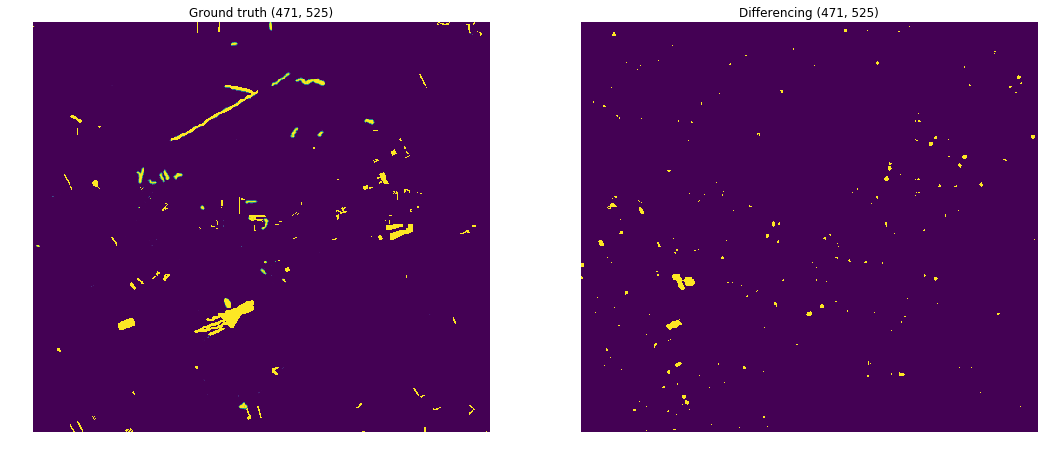

In [133]:
def generate_image_differencing(time1, time2, threshold=0.035):
    difference_image = abs(time1 - time2)
    binary_image = np.ndarray((time1.shape[0], time1.shape[1]))
    binary_image = np.any(difference_image[:, :] > threshold, axis=2)
    binary_image = binary_image.astype('float')
    return binary_image

cities_difference_image = [generate_image_differencing(cities_single_image_1[i], cities_single_image_2[i]) for i, c in enumerate(cities_single_image_1)]
show_compare(cities_ground_truths[1], cities_difference_image[1], 'Ground truth', 'Differencing')

## Resolvendo com PCA, segmentação e LBP

Gerando uma única imagem (3 componentes principais) usando PCA

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage import exposure

def generate_pca3_image_from_13_bands(image):
    scaler = StandardScaler()
    # converte dataset 3d para 2d
    width, height, bands = image.shape
    image_2d = image.reshape((width*height, bands))
    # fit nos dados
    scaler.fit(image_2d)
    # transforma a imagem de acordo com o rescaler
    normalized_image = scaler.transform(image_2d)
    # instancia o modelo pca e o aplica à imagem
    pca = PCA(n_components=4)
    pca.fit(normalized_image)
    pca_image = pca.transform(normalized_image)
    return pca_image.reshape((width, height, 4))[:, :, 1:4]

cities_pca_t1 = [generate_pca3_image_from_13_bands(city_single_image) for city_single_image in cities_single_image_1]
cities_pca_t1 = [exposure.rescale_intensity(city_pca, out_range=(0,1)) for city_pca in cities_pca_t1]
cities_pca_t2 = [generate_pca3_image_from_13_bands(city_single_image) for city_single_image in cities_single_image_2]
cities_pca_t2 = [exposure.rescale_intensity(city_pca, out_range=(0,1)) for city_pca in cities_pca_t2]


Segmentando a imagem PCA usando SLIC

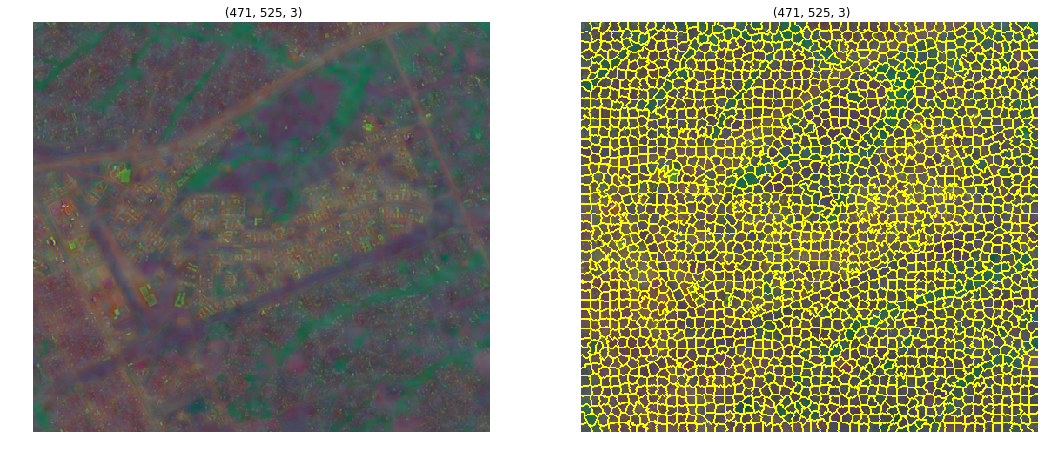

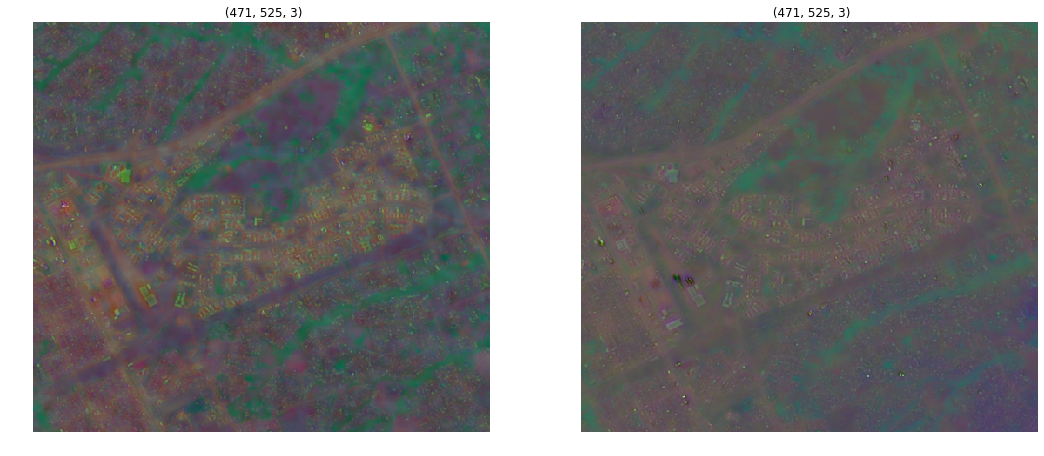

In [135]:
# computando o SLIC
from skimage import img_as_float
from skimage import segmentation
from skimage import color


cities_labels = [segmentation.slic(city_pca, compactness=20, n_segments=2000, sigma=0) for city_pca in cities_pca_t1]
show_compare(cities_pca_t1[1], segmentation.mark_boundaries(cities_pca_t1[1], cities_labels[1]))
show_compare(cities_pca_t1[1], cities_pca_t2[1])


Extraindo características dos segmentos com histograma de LBP de t1 e t2

In [136]:
from skimage.feature import local_binary_pattern

# calcula LBP em t1 e t2
lbp_radius = 2
lbp_points = lbp_radius * 8
lbp_method = 'nri_uniform'


def get_city_lbp(city_pca):
    city_lbp = [local_binary_pattern(city_pca[:, :, band], lbp_points, lbp_radius, lbp_method) for band in range(3)]
    city_lbp = np.array(city_lbp)
    city_lbp = np.moveaxis(city_lbp, 0, -1)
    return city_lbp

cities_lbp_t1 = [get_city_lbp(city_pca) for city_pca in cities_pca_t1]
cities_lbp_t2 = [get_city_lbp(city_pca) for city_pca in cities_pca_t2]


# separa os pixels de cada segmento
def get_euclidian_distance_between_segments(labels, lbp_t1, lbp_t2):
    segments_total = np.max(labels)
    segments_euclidian_distance = []
    for segment_id in range(segments_total):
        # seleciona apenas os pixels deste segmento
        segment_mask = labels == segment_id
        segment_values_t1 = lbp_t1[segment_mask]
        segment_values_t2 = lbp_t2[segment_mask]
        
        # gera os histogramas da imagem lbp deste segmento para t1 e t2
        segment_max_t1 = segment_values_t1.max().astype(int)
        segment_max_t2 = segment_values_t2.max().astype(int)
        segment_bins = max(segment_max_t1, segment_max_t2) + 1
        segment_histogram_t1, _ = np.histogram(segment_values_t1, bins=segment_bins, range=(0, segment_bins))
        segment_histogram_t2, _ = np.histogram(segment_values_t2, bins=segment_bins, range=(0, segment_bins))

        # computa a distância euclidiana dos histogramas t1 e t2
        euclidian_distance = np.linalg.norm(segment_histogram_t1-segment_histogram_t2)
        segments_euclidian_distance.append(euclidian_distance)
    return np.array(segments_euclidian_distance)


# calcula a distância euclidiana entre cada segmento, de cada cidade, de t1 para t2
cities_segments_euclidian_distance = [get_euclidian_distance_between_segments(labels, cities_lbp_t1[i], cities_lbp_t2[i]) for i, labels in enumerate(cities_labels)]


Comparando as _features_ dos segmentos de acordo com um _threshold_

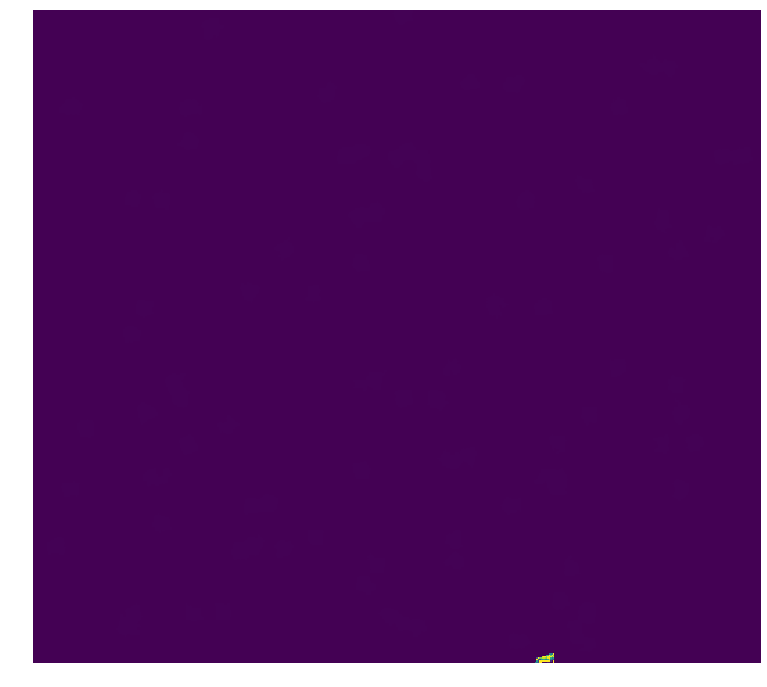

In [137]:
def get_threshold_for_city(distances):
    distance_average = np.mean(distances)
    distance_deviation = np.std(distances)
    threshold = distance_average + 2*distance_deviation
    return threshold

def generate_binary_map(distances, threshold, labels):
    segment_changed = list(map(lambda distance: distance > threshold, distances))

    binary_map = np.ndarray(labels.shape)
    for segment_id in range(np.max(labels)):
        # seleciona apenas os pixels deste segmento
        segment_mask = labels == segment_id
        binary_map[segment_mask] = segment_changed[segment_id]
    
    return binary_map.astype(int)
    

    
# acha um threshold = média + 2*desvio da distância euclidiana
cities_thresholds = [get_threshold_for_city(distances) for distances in cities_segments_euclidian_distance]

# classifica em mudança/não-mudança
cities_binary_maps = [generate_binary_map(cities_segments_euclidian_distance[i], cities_thresholds[i], labels) for i, labels in enumerate(cities_labels)]
show(cities_binary_maps[1])

## Comparação com _ground truth_

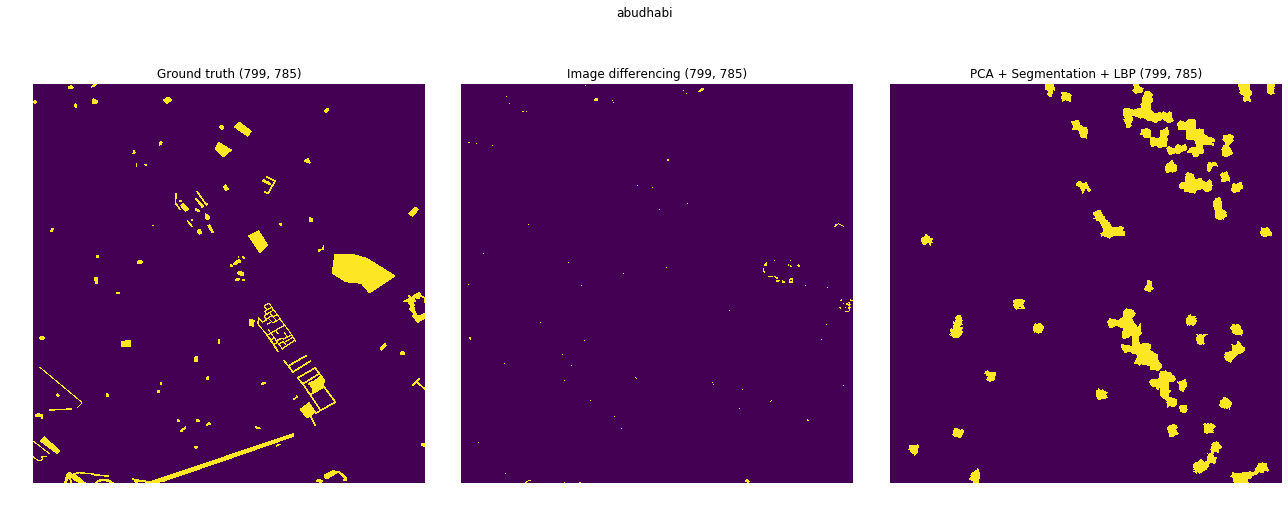

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
abudhabi             0.9119415248405822   0.9553358896072319   0.8459444025941698   0.90906945784141    


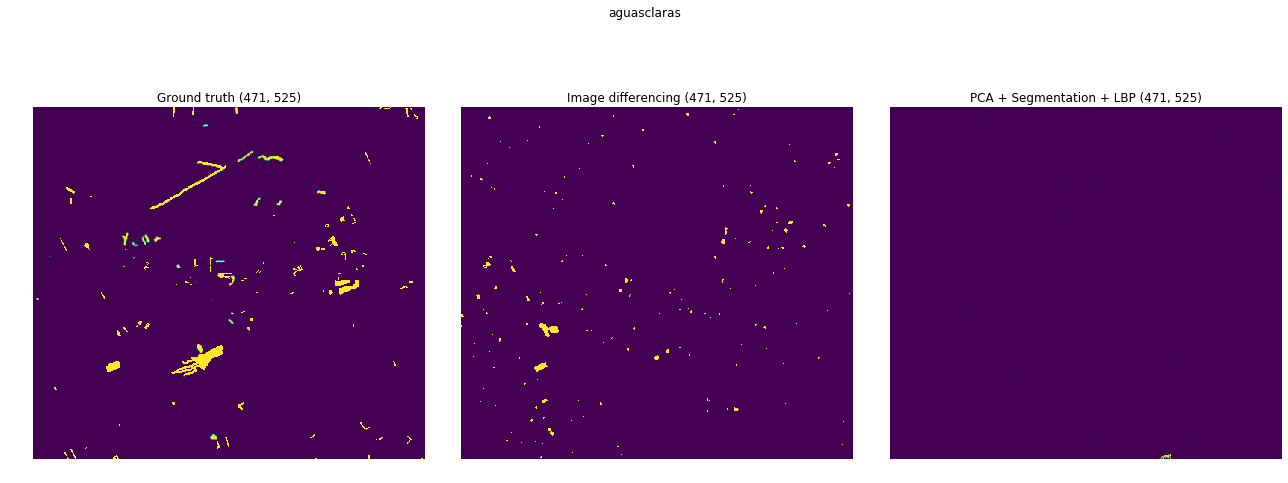

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
aguasclaras          0.879642164034339    0.9732524517237893   0.8196085167434672   0.9312506318875745  


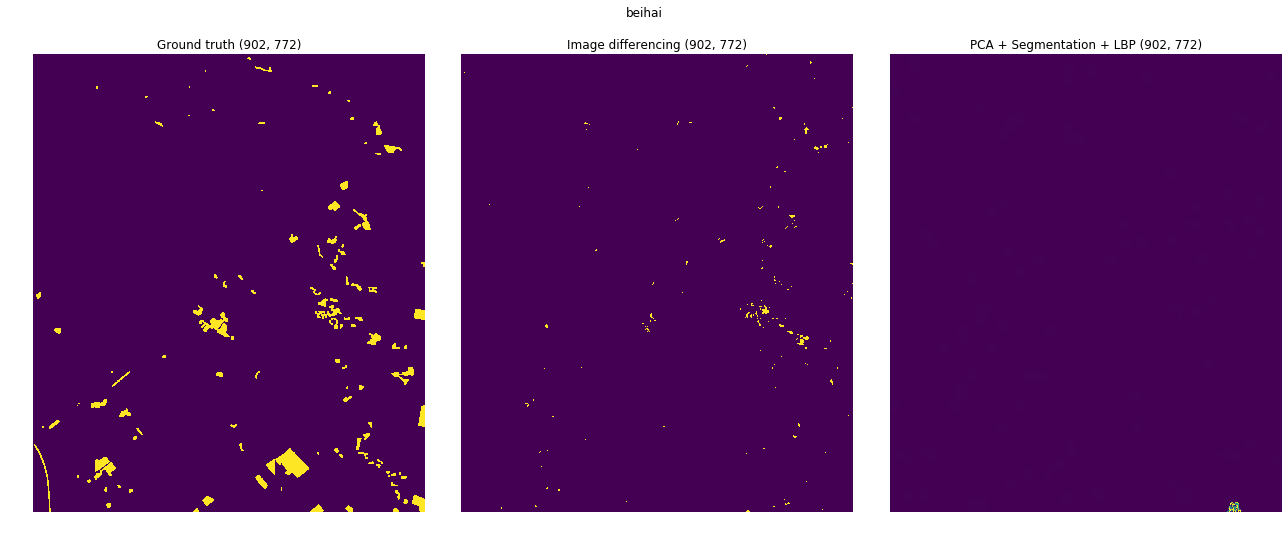

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
beihai               0.9367033078449362   0.972148822995531    0.8629480883122239   0.9256674861849891  


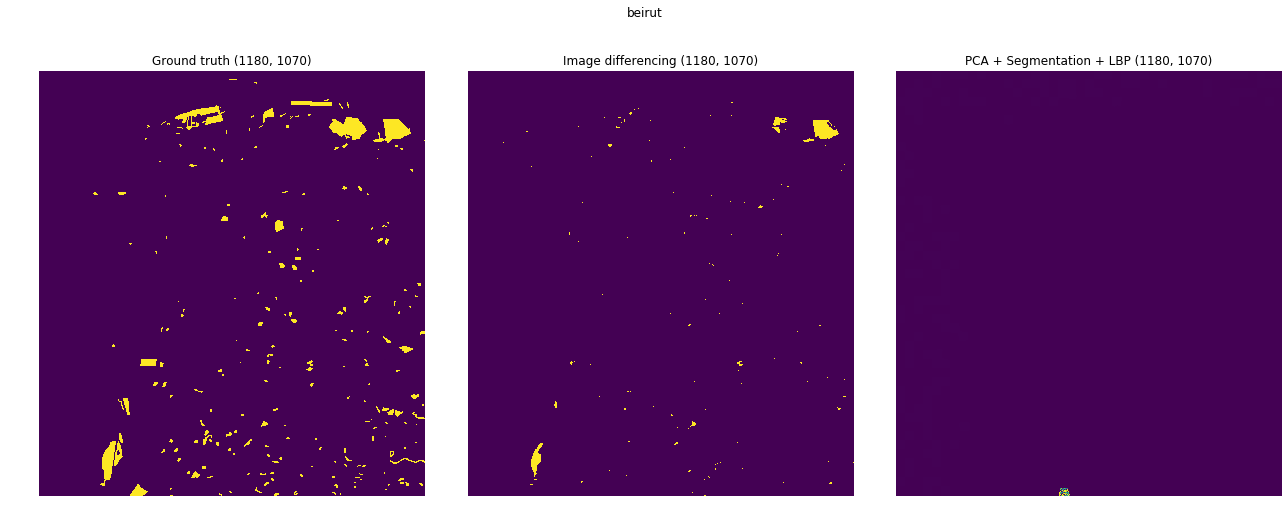

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
beirut               0.9374678159483565   0.974184223031839    0.8493887579654017   0.8987612862347537  


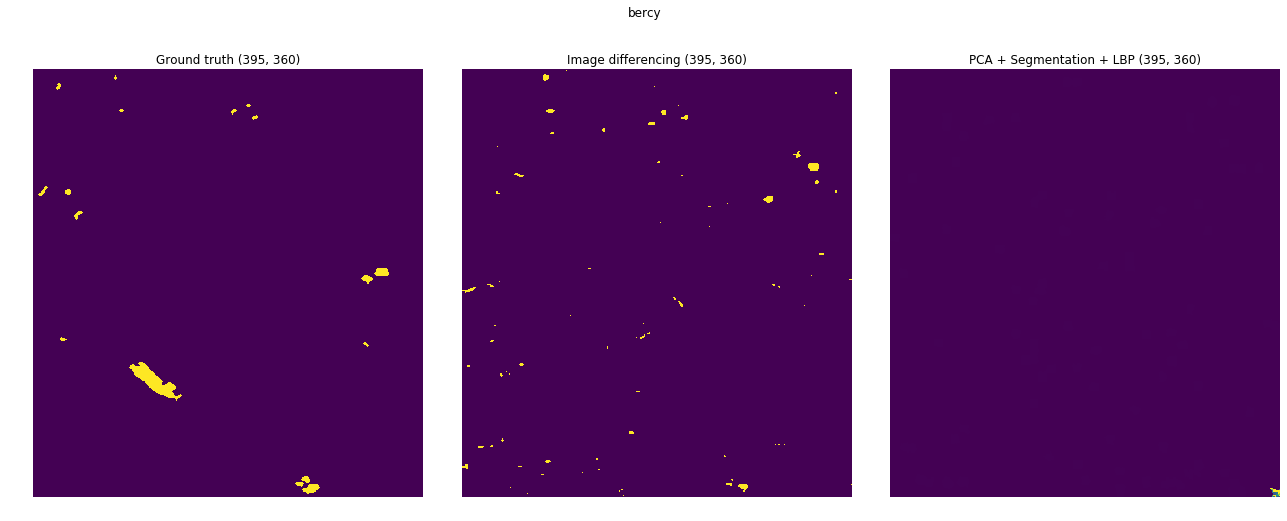

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
bercy                0.9484649258464538   0.9883403656821378   0.8588532560276023   0.9500773558368495  


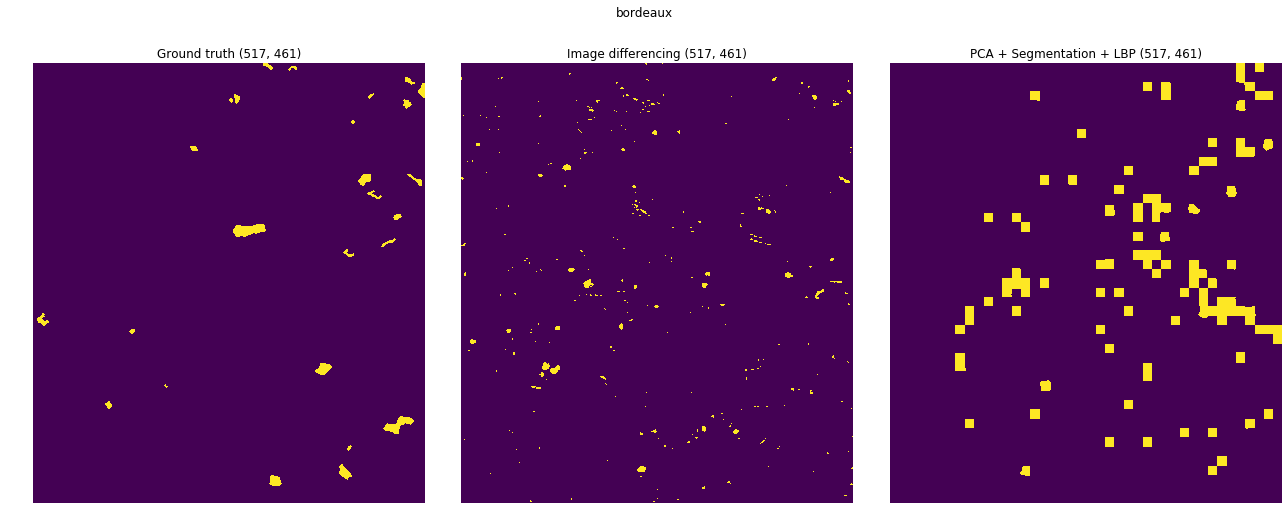

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
bordeaux             0.8982631160101724   0.9807163805871518   0.8630789095487362   0.9343492617596093  


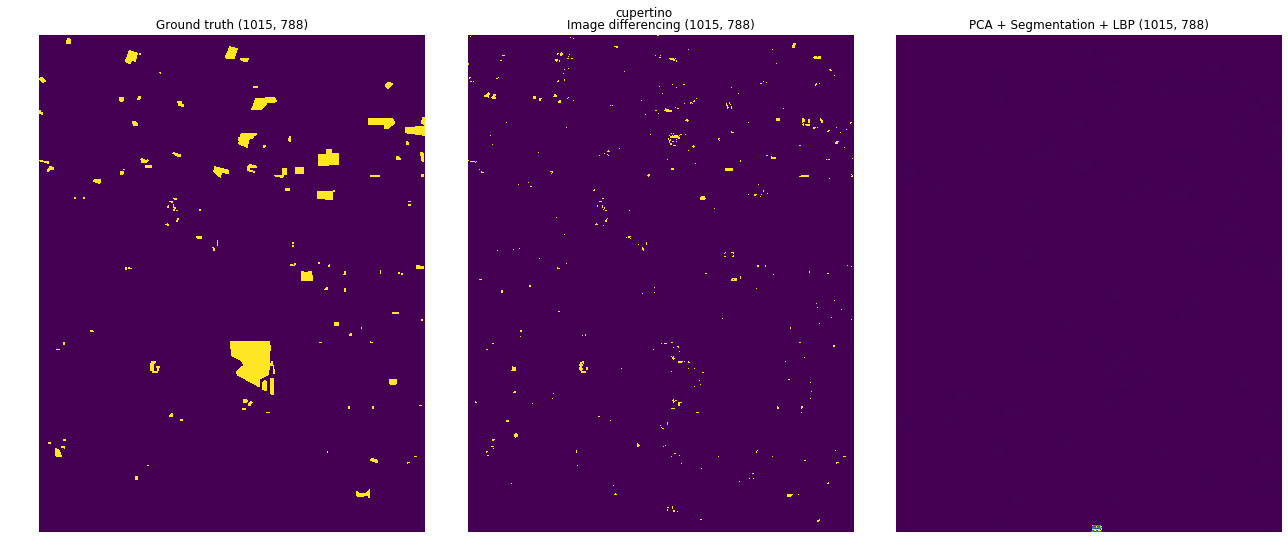

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
cupertino            0.9338548838177141   0.9728889000025006   0.9024204295853766   0.9459015778550174  


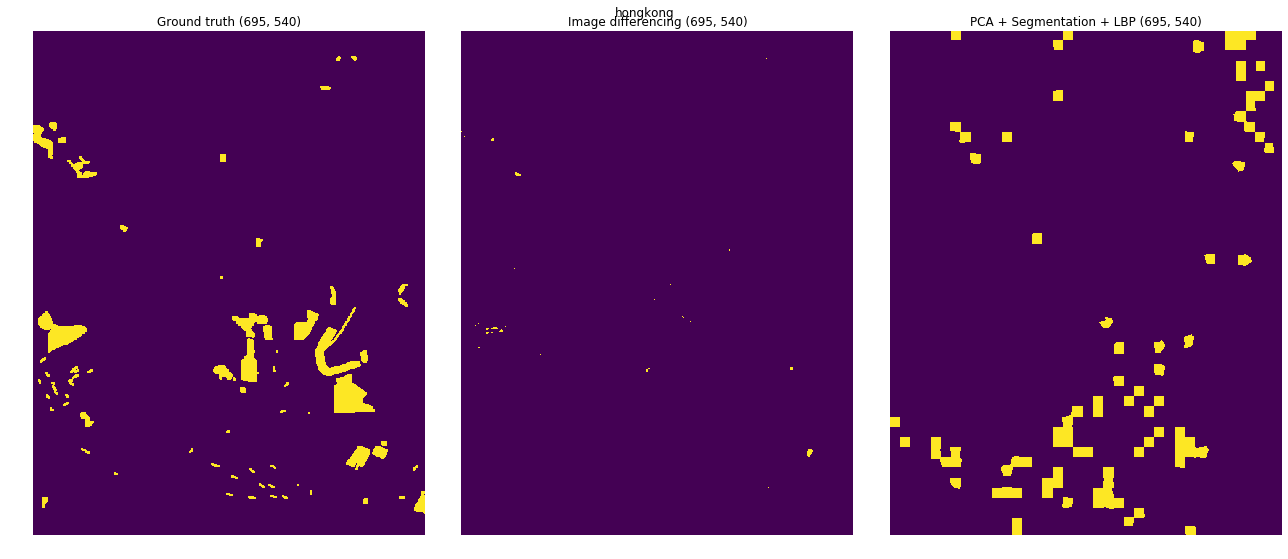

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
hongkong             0.925687759409909    0.96                 0.847815487968674    0.9138582467359446  


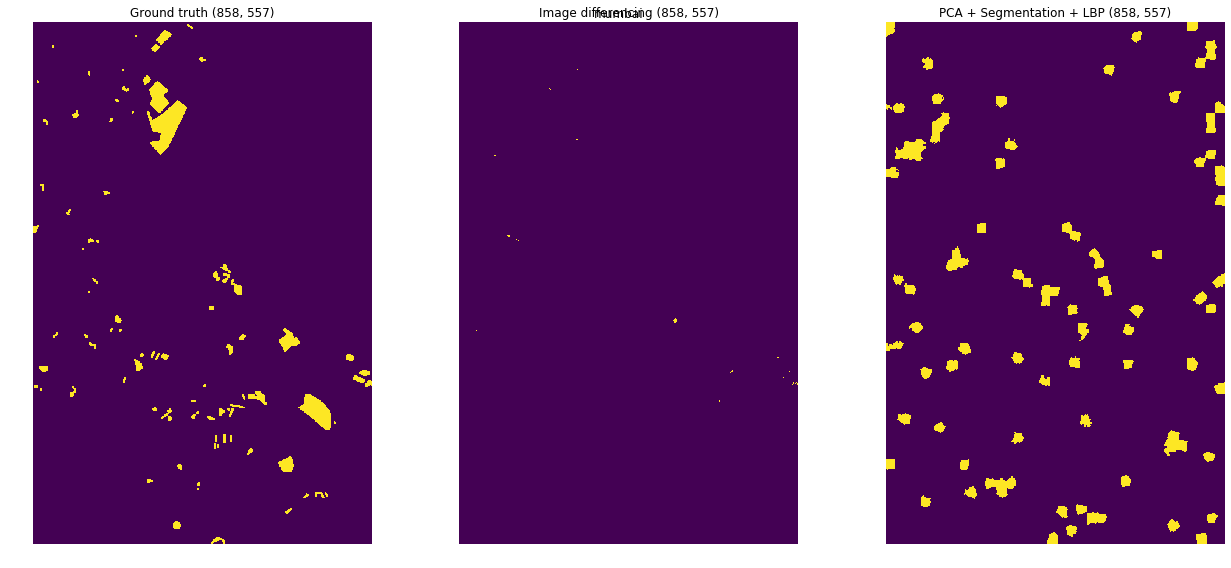

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
mumbai               0.941538612805354    0.9709503542537654   0.8537112144824839   0.9224617393378615  


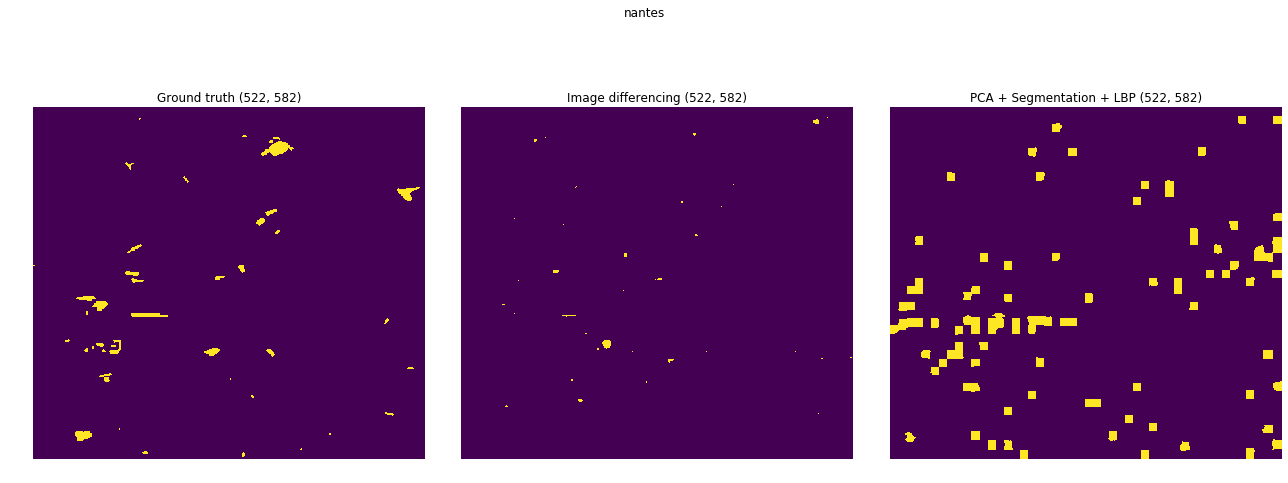

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
nantes               0.9557236845369275   0.9844669589603824   0.8723716596089149   0.9380258324446025  


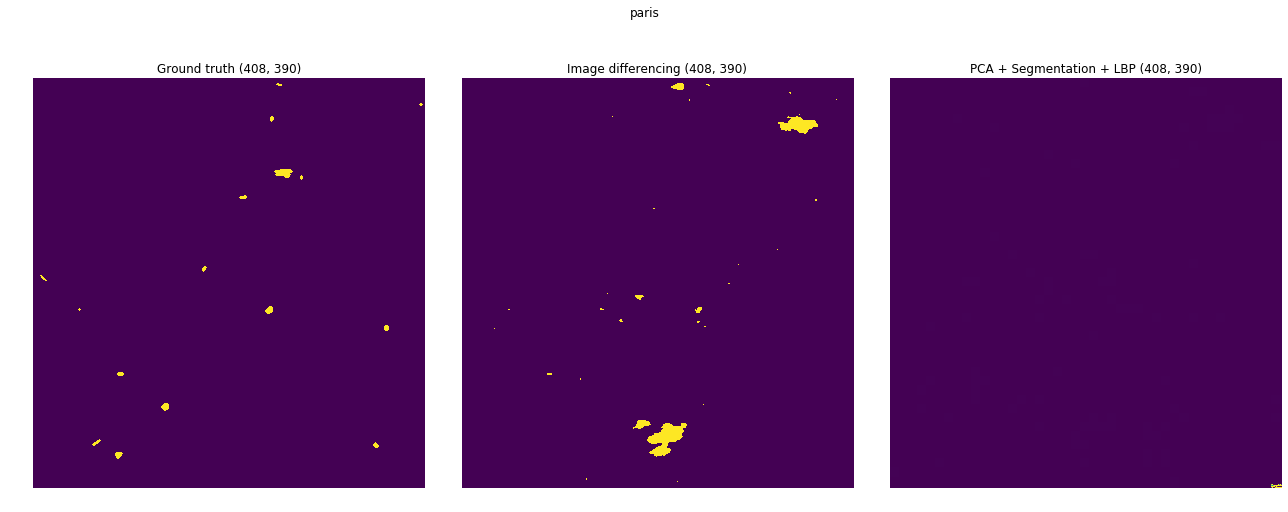

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
paris                0.962605602623278    0.9881284565108095   0.8847884298262697   0.9520236299648064  


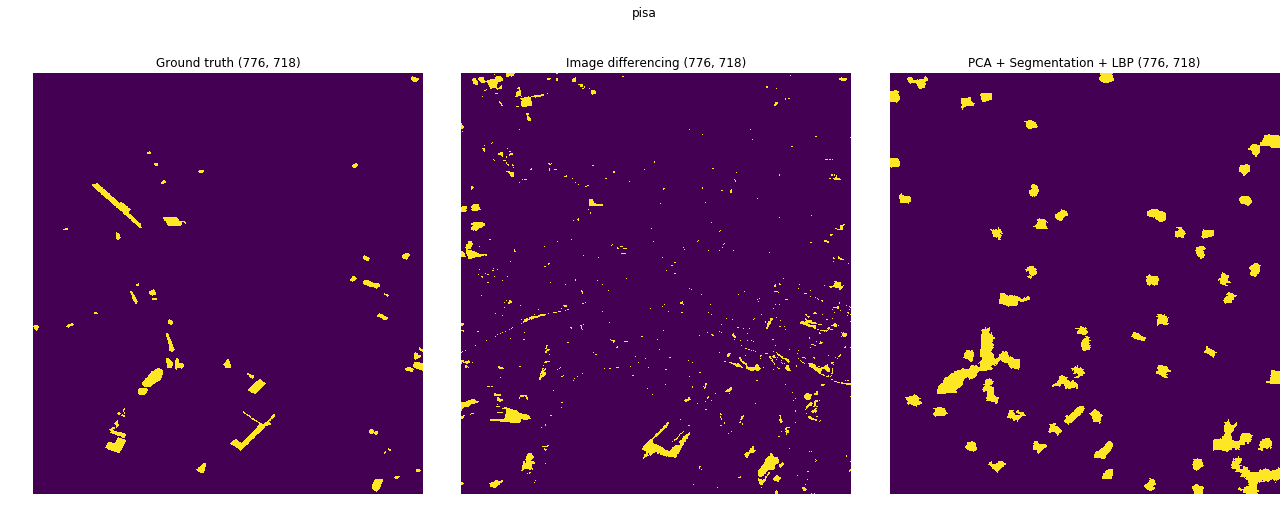

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
pisa                 0.848986951121504    0.9558840421560463   0.8768744821539423   0.932488944088677   


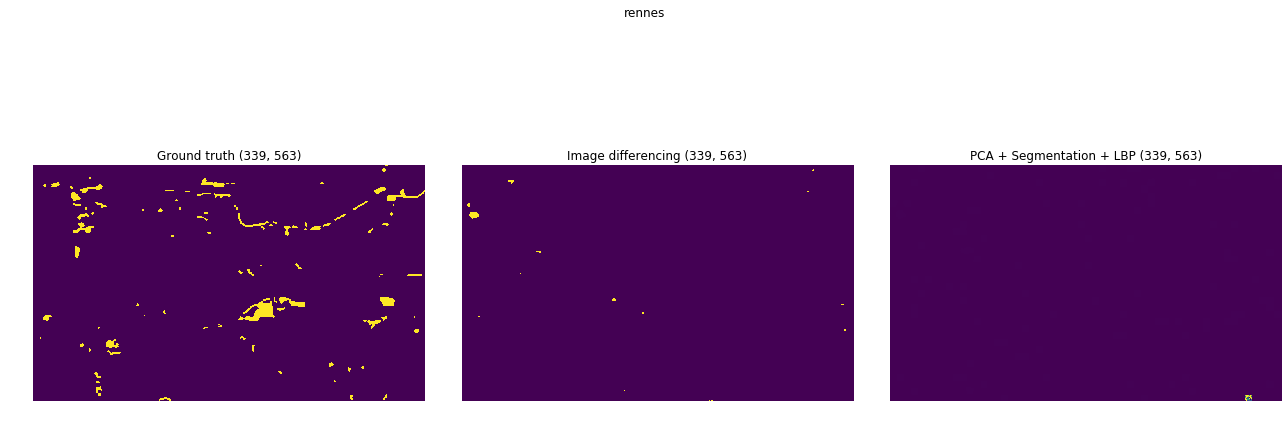

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
rennes               0.8980868929210587   0.9658225792085173   0.7904971314700906   0.9165762848624887  


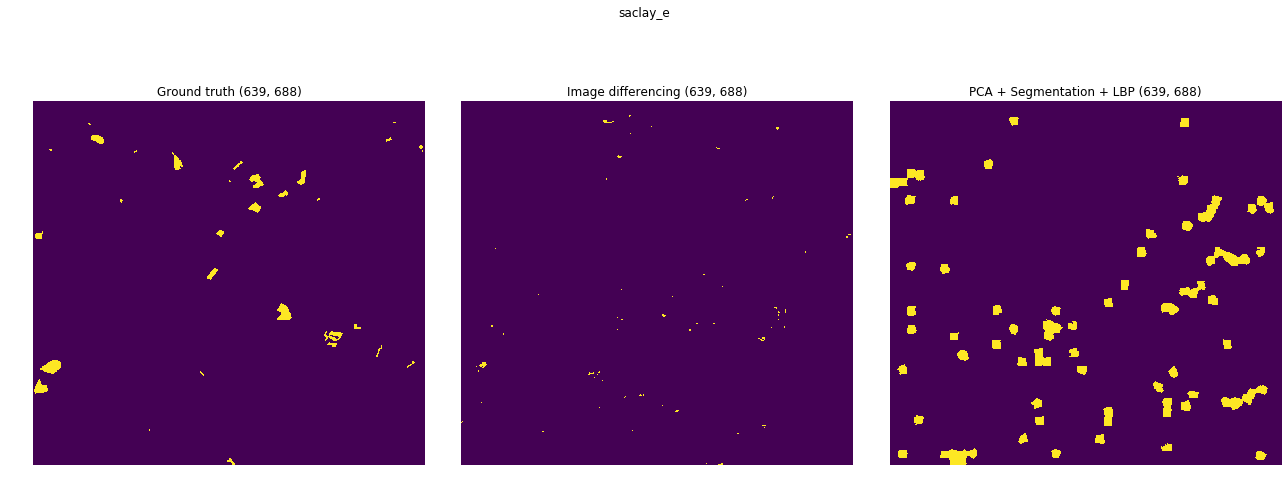

Cidade               Differencing (ssim)  Differencing (acc)   PCA/seg/LBP (ssim)   PCA/seg/LBP (acc)   
saclay_e             0.9637762986601469   0.9882947556137861   0.8917529821437845   0.944822032973032   


In [149]:
from skimage import measure

def show_compare_with_ground_truth(truth, result_image_differencing, result_pca_seg_lbp, title=''):
    fig, (truth_ax, result1_ax, result2_ax) = plt.subplots(1, 3, figsize=(18, 8))
    fig.suptitle(title)
    truth_ax.imshow(truth)
    truth_ax.set_axis_off()
    truth_ax.set_title('Ground truth {}'.format(truth.shape))
    result1_ax.imshow(result_image_differencing)
    result1_ax.set_axis_off()
    result1_ax.set_title('Image differencing {}'.format(result_image_differencing.shape))
    result2_ax.imshow(result_pca_seg_lbp)
    result2_ax.set_axis_off()
    result2_ax.set_title('PCA + Segmentation + LBP {}'.format(result_pca_seg_lbp.shape))
    fig.tight_layout()
    plt.show()
    
def get_comparison_indices(truth, test1_image, test2_image):
    ssim_1 = measure.compare_ssim(truth, test1_image)
    ssim_2 = measure.compare_ssim(truth, test2_image)
    difference_1 = abs(truth - test1_image)
    difference_2 = abs(truth - test2_image)
    different_pixels_1 = difference_1[difference_1 > 0].shape[0]
    different_pixels_2 = difference_2[difference_2 > 0].shape[0]
    all_pixels = truth.shape[0] * truth.shape[1]
    accuracy_1 = (all_pixels - different_pixels_1) / all_pixels
    accuracy_2 = (all_pixels - different_pixels_2) / all_pixels
    return {'ssim_1': ssim_1, 'accuracy_1': accuracy_1, 'ssim_2': ssim_2, 'accuracy_2': accuracy_2}


# para cada cidade, mostra imagem comparativa das técnicas e suas acurácias
cities_accuracies = []
for i, city in enumerate(cities_with_ground_truths):
    gt = cities_ground_truths[i]
    difference_image = cities_difference_image[i]
    pca_seg_lbp = cities_binary_maps[i]
    
    # mostra imagens desta cidade
    show_compare_with_ground_truth(gt, difference_image, pca_seg_lbp, city)
    
    # mostra índice ssim e acurácia desta cidade
    accuracy = get_comparison_indices(gt, difference_image, pca_seg_lbp)
    print("{:<20} {:<20} {:<20} {:<20} {:<20}".format('Cidade','Differencing (ssim)','Differencing (acc)','PCA/seg/LBP (ssim)','PCA/seg/LBP (acc)'))
    print("{:<20} {:<20} {:<20} {:<20} {:<20}".format(city, accuracy.get('ssim_1'), accuracy.get('accuracy_1'), accuracy.get('ssim_2'), accuracy.get('accuracy_2')))
    
    cities_accuracies.append(accuracy)





## Consolidação dos resultados

In [144]:
# imprime uma tabela com todos os resultados
import pandas as pd
csv_data = {
    'Cidade': cities_with_ground_truths,
    'Differencing (SSIM)': list(map(lambda acc: acc.get('ssim_1'), cities_accuracies)),
    'Differencing (acc)': list(map(lambda acc: acc.get('accuracy_1'), cities_accuracies)),
    'PCA/seg/LBP (SSIM)': list(map(lambda acc: acc.get('ssim_2'), cities_accuracies)),
    'PCA/seg/LBP (acc)': list(map(lambda acc: acc.get('accuracy_2'), cities_accuracies))
}

df = pd.DataFrame(csv_data, columns = ['Cidade', 'Differencing (SSIM)', 'Differencing (acc)', 'PCA/seg/LBP (SSIM)', 'PCA/seg/LBP (acc)'])
df.to_csv('results.csv')
df


,Cidade,Differencing (SSIM),Differencing (acc),PCA/seg/LBP (SSIM),PCA/seg/LBP (acc)
0,abudhabi,0.911942,0.955336,0.845944,0.909069
1,aguasclaras,0.879642,0.973252,0.819609,0.931251
2,beihai,0.936703,0.972149,0.862948,0.925667
3,beirut,0.937468,0.974184,0.849389,0.898761
4,bercy,0.948465,0.988340,0.858853,0.950077
5,bordeaux,0.898263,0.980716,0.863079,0.934349
6,cupertino,0.933855,0.972889,0.902420,0.945902
7,hongkong,0.925688,0.960000,0.847815,0.913858
8,mumbai,0.941539,0.970950,0.853711,0.922462
9,nantes,0.955724,0.984467,0.872372,0.938026
